In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt

In [74]:
class Backtest:
    
    def __init__(self, ticker, start, end):
        ma1 = 5
        ma2 = 15
        self.capital0 = 5000
        self.vol = 0.5
        self.ticker = ticker
        self.df = yf.download(ticker, start, end, progress = False)
        self.ewmacd(ma1, ma2)
        self.generate_signals(ma1, ma2)
        self.calc_pnl()

        self.cumuret_strat = self.df.strat_cumulative_return.iloc[-1]
        self.cumuret_base = self.df.base_cumulative_return.iloc[-1]

        # results
        print(f"Strategy Sharpe ratio: {self.sharpe('strategy_return')}  |  baseline Sharpe ratio: {self.sharpe('stock_return')}")
        print(f"Strategy CAGR: {self.cagr('total_asset')*100} %  |  baseline CAGR: {self.cagr('Close')*100} %")
        print(f"Strategy cumulative return: {self.cumuret_strat}  |  baseline cumulative return {self.cumuret_base}")

        self.plot(a='strat_cumulative_return', b='base_cumulative_return')
        
        
    def ewmacd(self, ma1, ma2):
        self.df[f'macd_{ma1}']=self.df['Close'].ewm(span=ma1).mean()   
        self.df[f'macd_{ma2}']=self.df['Close'].ewm(span=ma2).mean() 
        self.df.dropna(inplace = True)
        
    def generate_signals(self, ma1, ma2):
        self.df['positions'] = 0
        
        # condition to determine trading signals
        condition = self.df[f'macd_{ma1}'].iloc[ma1:] >= self.df[f'macd_{ma2}'].iloc[ma1:]
        
        self.df['positions'].iloc[ma1:] = np.where(condition, 1, 0)
        self.df['signals'] = self.df['positions'].diff()
        self.df['positions'] = self.df['positions'].shift()
        self.df['macd_oscillator'] = self.df[f'macd_{ma1}'] - self.df[f'macd_{ma2}']
        self.df.dropna(inplace = True)
        
    def calc_pnl(self):
        self.df['holding'] = self.df['positions']*self.df['Close']*self.vol
        self.df['cash'] = self.capital0 - (self.df['signals'].shift()*self.df['Open']*self.vol).cumsum() # buy at open
        self.df['cash'].iloc[0] = self.capital0
        # here multiply the close price with signals because signals are when we actually make the trade

        self.df['total_asset'] = self.df['holding'] + self.df['cash']
        self.df['stock_return'] = self.df['Close'].pct_change()
        self.df['strategy_return'] = self.df['total_asset'].pct_change()

        self.df['strat_cumulative_return'] = (self.df['strategy_return'] + 1).cumprod()
        self.df['base_cumulative_return'] = (self.df['stock_return'] + 1).cumprod()
        
    def sharpe(self, cond):
        return (self.df[cond].mean() / \
                self.df[cond].std()
               ) * np.sqrt(252)

    def cagr(self, cond):
        D = (self.df.index[-1] - self.df.index[0]).days
        return (self.df[cond].iloc[-1] / self.df[cond].iloc[0])**(365/D) - 1
        
    def plot(self, **item):
        # plot the value of the selected item (column)
        items = []
        for i in item.values():
            items.append(i)

        self.df[items].plot(figsize = (16,10))

<ipython-input-74-3b68992a76a7>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['positions'].iloc[ma1:] = np.where(condition, 1, 0)
<ipython-input-74-3b68992a76a7>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['cash'].iloc[0] = self.capital0


Strategy Sharpe ratio: 1.603010818568054  |  baseline Sharpe ratio: 0.708965313756448
Strategy CAGR: 183.74347619516863 %  |  baseline CAGR: 36.9026395992625 %
Strategy cumulative return: 1.3006550781250008  |  baseline cumulative return 1.0823887101562968


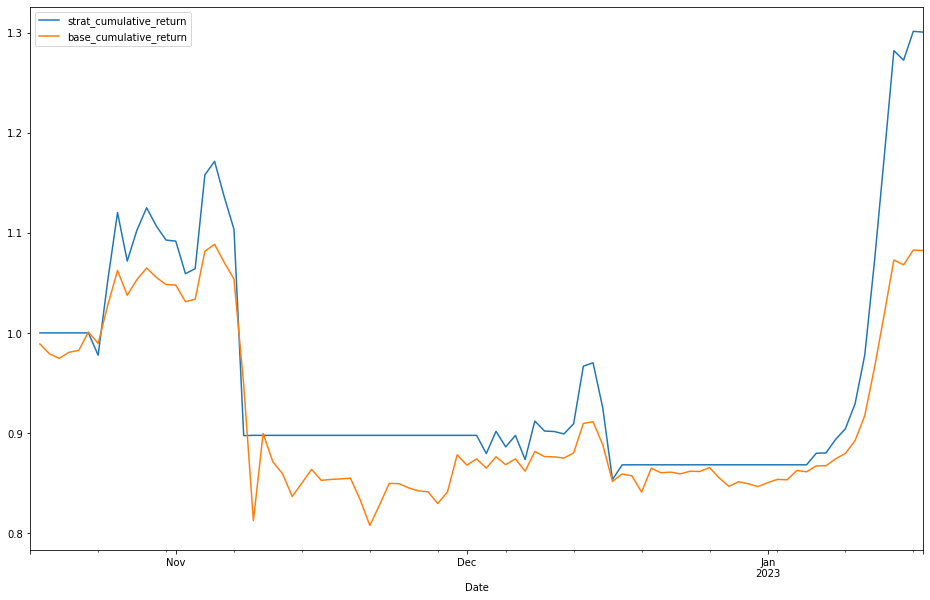

In [77]:
start = dt.datetime(2022,10,17)
end = dt.datetime(2023,1,18)

backtest = Backtest('BTC-USD', start, end)

In [78]:
backtest.df.tail(25)

,Open,High,Low,Close,Adj Close,Volume,macd_5,macd_15,positions,signals,macd_oscillator,holding,cash,total_asset,stock_return,strategy_return,strat_cumulative_return,base_cumulative_return
Date,,,,,,,,,,,,,,,,,,
2022-12-24,16796.976562,16864.703125,16793.527344,16847.755859,16847.755859,9744636213,16826.464517,16913.433548,0.0,0.0,-86.969031,0.000000,4340.751953,4340.751953,0.003025,0.000000,0.868150,0.861744
2022-12-25,16847.505859,16860.554688,16755.253906,16841.986328,16841.986328,11656379938,16831.638454,16904.501964,0.0,0.0,-72.863510,0.000000,4340.751953,4340.751953,-0.000342,0.000000,0.868150,0.861449
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804,16861.027199,16906.414932,0.0,0.0,-45.387733,0.000000,4340.751953,4340.751953,0.004620,0.000000,0.868150,0.865430
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239,16813.076075,16882.758412,0.0,0.0,-69.682337,0.000000,4340.751953,4340.751953,-0.011976,0.000000,0.868150,0.855065
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920,16726.241472,16841.483034,0.0,0.0,-115.241562,0.000000,4340.751953,4340.751953,-0.009846,0.000000,0.868150,0.846646
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479,16698.274914,16816.589265,0.0,0.0,-118.314352,0.000000,4340.751953,4340.751953,0.005423,0.000000,0.868150,0.851238
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910,16666.378588,16789.837802,0.0,0.0,-123.459214,0.000000,4340.751953,4340.751953,-0.002389,0.000000,0.868150,0.849204
2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,16547.496094,11239186456,16626.751090,16759.544051,0.0,0.0,-132.792961,0.000000,4340.751953,4340.751953,-0.003318,0.000000,0.868150,0.846386
2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,16625.080078,9244361700,16626.194086,16742.735551,0.0,0.0,-116.541465,0.000000,4340.751953,4340.751953,0.004689,0.000000,0.868150,0.850355
